# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from tqdm.notebook import trange, tqdm

In [3]:
set_config(display='diagram')

In [4]:
import warnings
# to ignore ConvergenceWarning where alpha=0 and regularization may work incorrectly
warnings.filterwarnings("ignore")

## Settings

In [5]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [6]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

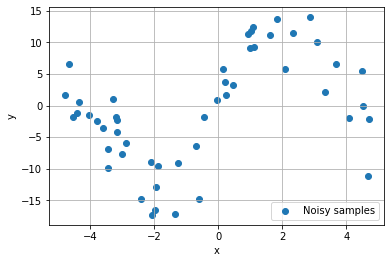

In [7]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

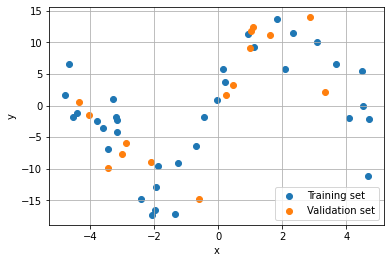

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [9]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [10]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [11]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=70000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=70000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=70000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=70000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

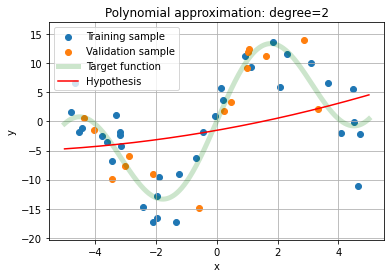

In [12]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

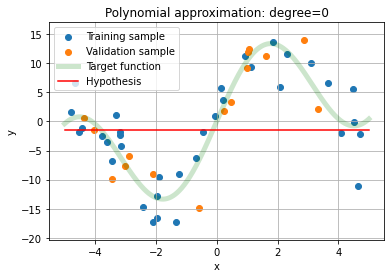

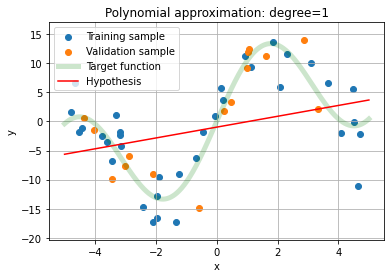

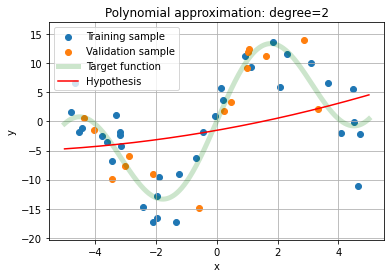

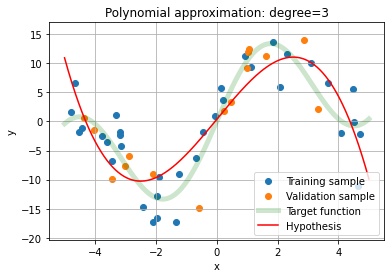

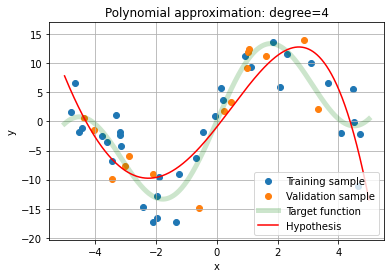

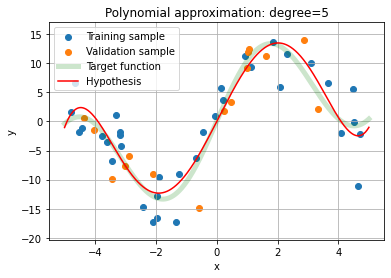

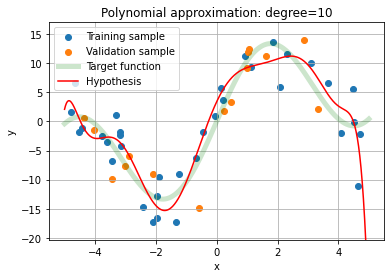

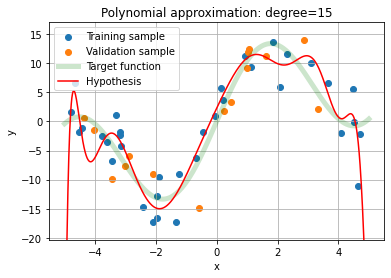

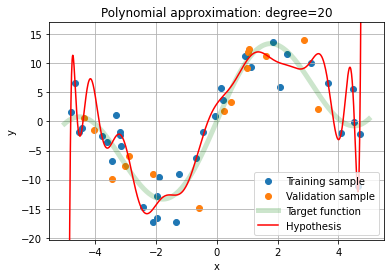

In [13]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

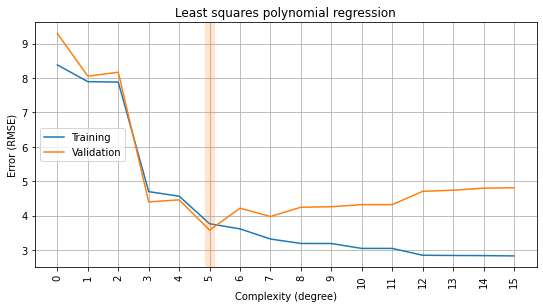

In [14]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [15]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

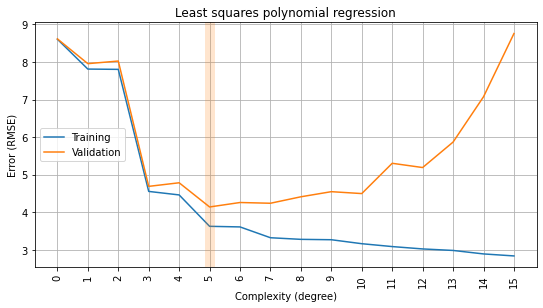

In [16]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [17]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

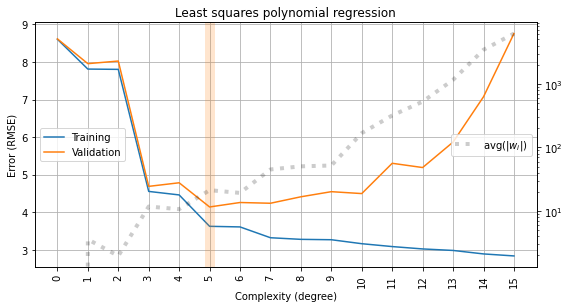

In [18]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

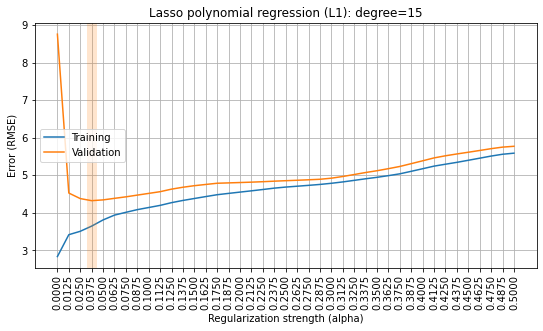

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

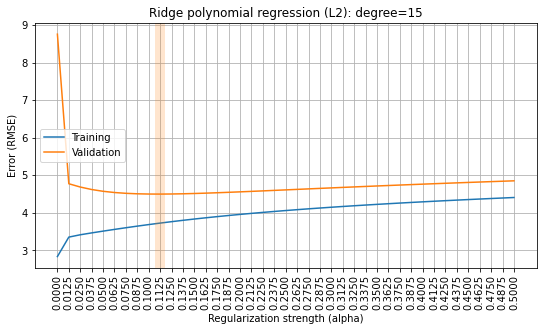

In [20]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you must collect all features together (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [21]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

First, let's split our data into training and validation parts. We do it before all the data manipulations to use the same datasets for analyzing.

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

How are our featutes distributed?

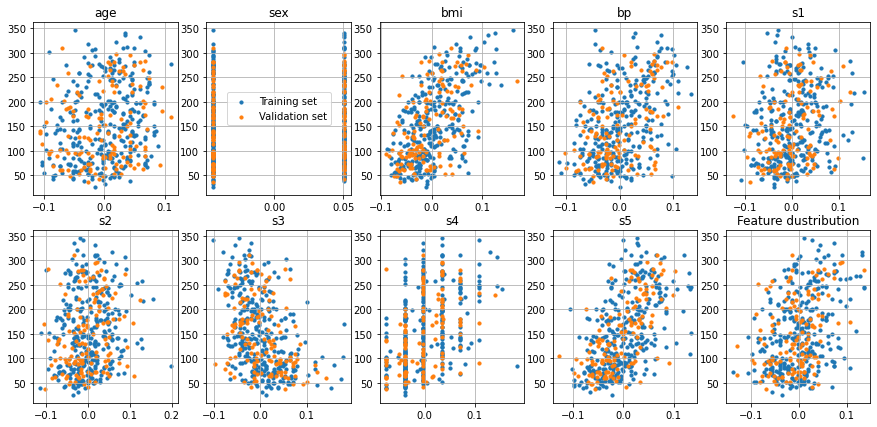

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))

columns = data['feature_names']
for i in range(10):
    axes[i // 5][i % 5].scatter(X_train.loc[:, columns[i]], y_train, label='Training set', s=10)
    axes[i // 5][i % 5].scatter(X_valid.loc[:, columns[i]], y_valid, label='Validation set', s=10)
    axes[i // 5][i % 5].set_title(columns[i])
    axes[i // 5][i % 5].grid(True)
axes[0][1].legend(loc='center')
plt.title('Feature dustribution')
plt.show()

Choosing columns to transform:

In [24]:
cols_to_transform = ['age', 'sex', 'bmi', 's6']
cols_to_leave = [col for col in data['feature_names'] if col not in cols_to_transform]
cols_to_leave

['bp', 's1', 's2', 's3', 's4', 's5']

In [25]:
def make_model_hw(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=70000)
    # ridge regression
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=70000) 
    
    
    return Pipeline([
        ('coltr', ColumnTransformer(
            [('pol', PolynomialFeatures(degree, include_bias=(degree == 0)), cols_to_transform)], \
            remainder='passthrough')),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

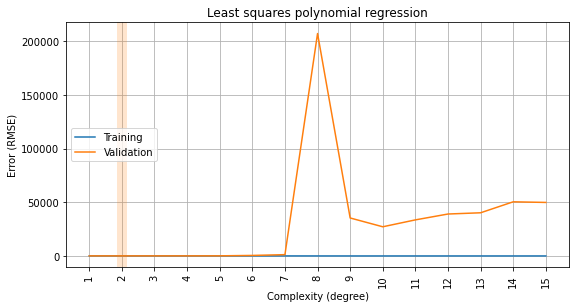

In [26]:
rmse_train, rmse_valid = [], []

for degree in DEGREES[1:]:
    reg = make_model_hw(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))

plot_fitting_graph(DEGREES[1:], rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

Let's look at the RMSE values for first 4 degrees.

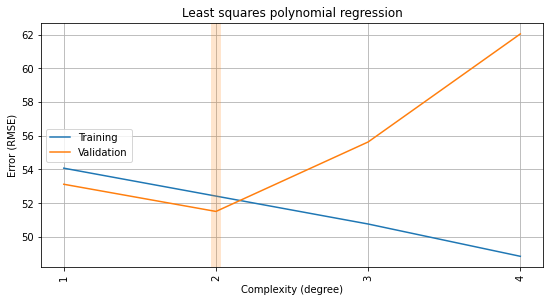

In [27]:
plot_fitting_graph(DEGREES[1:5], rmse_train[:4], rmse_valid[:4], xlabel='Complexity (degree)', \
                   ylabel='Error (RMSE)', title='Least squares polynomial regression')

Let's do the same with crossvalidation.

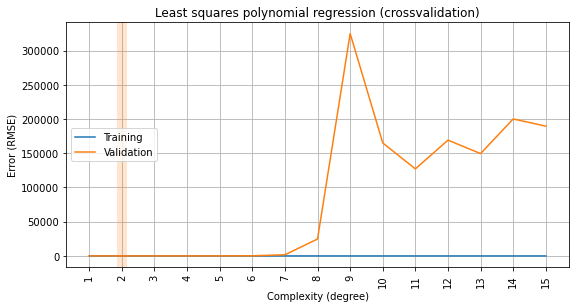

In [28]:
rmse_train_cv, rmse_valid_cv = [], []

for degree in DEGREES[1:]:
    results = cross_validate(make_model_hw(degree), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_cv.append(-np.mean(results['train_score']))
    rmse_valid_cv.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES[1:], rmse_train_cv, rmse_valid_cv, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression (crossvalidation)')

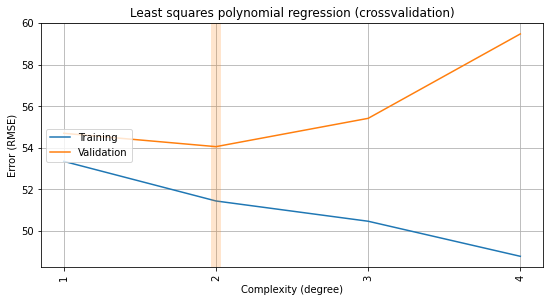

In [29]:
plot_fitting_graph(DEGREES[1:5], rmse_train_cv[:4], rmse_valid_cv[:4], xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression (crossvalidation)')

#### Summary

In [30]:
print(f'Min RMSE for Least squares polynomial regression \nusing train_test_split(): {np.min(rmse_valid)}; \n' \
      f'using crossvalidation: {np.min(rmse_valid_cv)}.')

Min RMSE for Least squares polynomial regression 
using train_test_split(): 51.507462106511404; 
using crossvalidation: 54.04873358649304.


We got better results using `train_test_split()` method.

Let's save our data in a DataFrame for further steps.

In [31]:
regul_res = pd.DataFrame(index=['Least squares best', 'Least squares d=15', 'Lasso', 'Ridge'], \
                         columns=['RMSE', 'Degree', 'Alpha'])

rmse_ls = np.min(rmse_valid)
degree = DEGREES[np.argmin(rmse_valid) + 1]
regul_res.loc['Least squares best'] = [rmse_ls, degree, 0]

rmse_ls_15 = rmse_valid[-1]
regul_res.loc['Least squares d=15'] = [rmse_ls_15, 15, 0]

regul_res

,RMSE,Degree,Alpha
Least squares best,51.507462,2,0
Least squares d=15,49831.21564,15,0
Lasso,NaN,NaN,NaN
Ridge,NaN,NaN,NaN


In [32]:
# your findings/conclusions

 > 2 is degree with the best validation error (51.5075).
 
 > With the larger degrees model overfits. With the first degree - underfits.


### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

  0%|          | 0/41 [00:00<?, ?it/s]

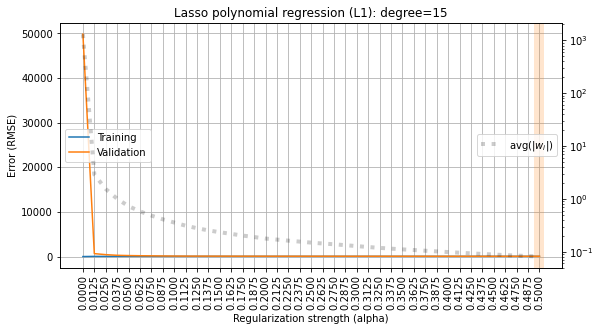

In [33]:
# your code
rmse_train_l1, rmse_valid_l1, avg_coef_l1 = [], [], []
all_coef_l1 = {'min':[], 'max':[]}

for alpha in tqdm(ALPHAS):
    model = make_model_hw(degree=15, alpha=alpha, penalty='L1').fit(X_train, y_train)
    rmse_train_l1.append(rmse(model.predict(X_train), y_train))
    rmse_valid_l1.append(rmse(model.predict(X_valid), y_valid))
    avg_coef_l1.append(np.mean(np.abs(model['reg'].coef_)))
    all_coef_l1['min'].append(model['reg'].coef_.min())
    all_coef_l1['max'].append(model['reg'].coef_.max())
    
plot_fitting_graph(ALPHAS, rmse_train_l1, rmse_valid_l1,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_l1, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')

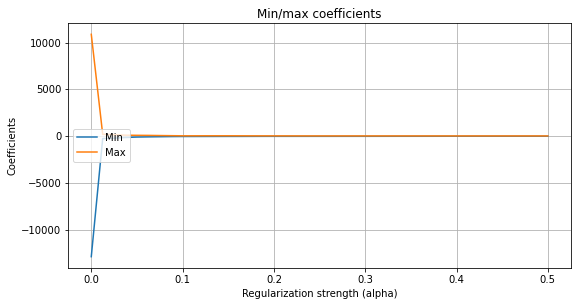

In [34]:
plt.figure(figsize=(9, 4.5))
plt.plot(ALPHAS, all_coef_l1['min'], label='Min')
plt.plot(ALPHAS, all_coef_l1['max'], color='C1', label='Max')
plt.title('Min/max coefficients')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Coefficients')
plt.grid(True)
plt.legend(loc='center left')            
plt.show()

Lasso regression with alpha=0 is the same as Least squares regression. So we can conclude, that using Lasso regression reduces mean values of weights. In other words, L1 regression constraints them. 

Let's look what's going on with RMSE values for alpha>0.

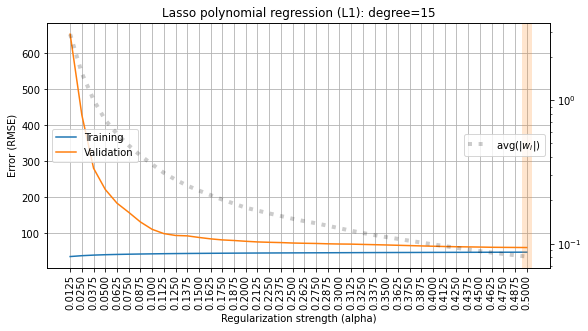

In [35]:
plot_fitting_graph(ALPHAS[1:], rmse_train_l1[1:], rmse_valid_l1[1:],
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_l1[1:], custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')

In [36]:
# adding results to the table
best_alpha_l1 = ALPHAS[np.argmin(rmse_valid_l1)]
rmse_l1 = np.min(rmse_valid_l1)
regul_res.loc['Lasso'] = [rmse_l1, 15, best_alpha_l1]

#### L2

  0%|          | 0/41 [00:00<?, ?it/s]

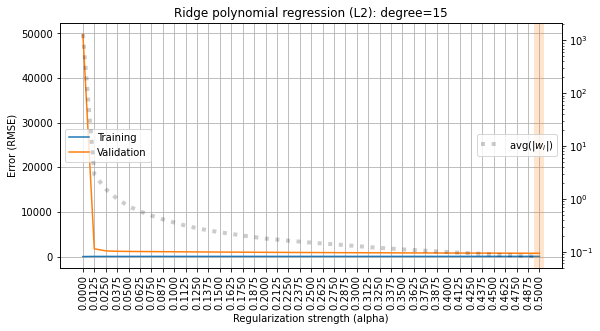

In [37]:
rmse_train_l2, rmse_valid_l2, avg_coef_l2 = [], [], []
all_coef_l2 = {'min':[], 'max':[]}

for alpha in tqdm(ALPHAS):
    model = make_model_hw(degree=15, alpha=alpha, penalty='L2').fit(X_train, y_train)
    rmse_train_l2.append(rmse(model.predict(X_train), y_train))
    rmse_valid_l2.append(rmse(model.predict(X_valid), y_valid))
    avg_coef_l2.append(np.mean(np.abs(model['reg'].coef_)))
    all_coef_l2['min'].append(model['reg'].coef_.min())
    all_coef_l2['max'].append(model['reg'].coef_.max())
    
plot_fitting_graph(ALPHAS, rmse_train_l2, rmse_valid_l2,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_l1, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

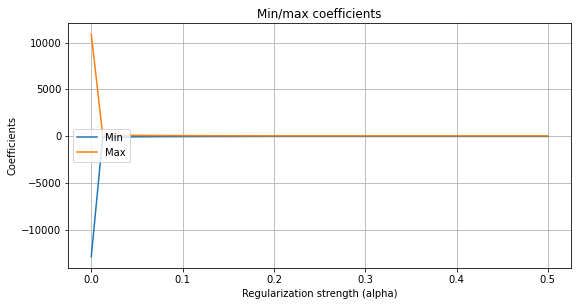

In [38]:
plt.figure(figsize=(9, 4.5))
plt.plot(ALPHAS, all_coef_l2['min'], label='Min')
plt.plot(ALPHAS, all_coef_l2['max'], color='C1', label='Max')
plt.title('Min/max coefficients')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Coefficients')
plt.grid(True)
plt.legend(loc='center left')            
plt.show()

Here we can also conclude, that Ridge (L2) regression constraints the weights. 

Let's look what's going on with RMSE values for alpha>0.

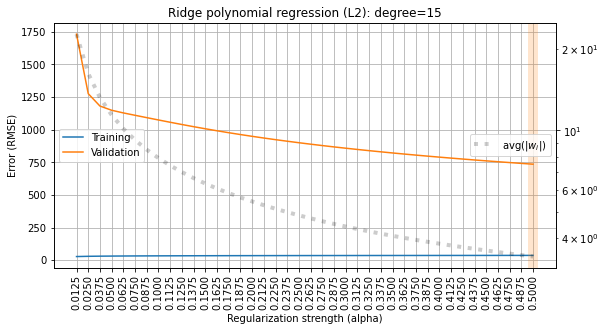

In [39]:
plot_fitting_graph(ALPHAS[1:], rmse_train_l2[1:], rmse_valid_l2[1:],
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_l2[1:], custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

In [40]:
# adding results to the table
best_alpha_l2 = ALPHAS[np.argmin(rmse_valid_l2)]
rmse_l2 = np.min(rmse_valid_l2)
regul_res.loc['Ridge'] = [rmse_l2, 15, best_alpha_l2]

#### Summary

Let's look what best RMSE we got with different regularization methods.

In [41]:
regul_res

,RMSE,Degree,Alpha
Least squares best,51.507462,2,0
Least squares d=15,49831.21564,15,0
Lasso,60.915349,15,0.5
Ridge,735.984009,15,0.5


As we can see, both L1 and L2 regressions gave us much better results for high degree (=15). Probably, it could be even better using lareger alpha value. Furthermore, both L1 and L2 regressions constrainted the weights.

The best result for degree=15 we can see by Lasso L1 regression.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [42]:
coef_l1 = []

for alpha in tqdm(ALPHAS):
    model = make_model_hw(degree=15, alpha=alpha, penalty='L1').fit(X_train, y_train)
    coef_l1.append(model['reg'].coef_.reshape(-1).tolist())
print(f'There are {len(coef_l1[0])} features at all.')
print(f'Number of non-zero weights in different models: ' + \
      ', '.join(str(x) for x in np.unique(np.count_nonzero(coef_l1, axis=1))))

  0%|          | 0/41 [00:00<?, ?it/s]

There are 3881 features at all.
Number of non-zero weights in different models: 75, 76, 77, 79, 80, 84, 85, 86, 87, 89, 91, 92, 93, 95, 97, 100, 102, 113, 114, 116, 120, 123, 127, 149, 153, 172, 218, 322, 3881


#### L2

In [43]:
# your code
coef_l2 = []

for alpha in tqdm(ALPHAS):
    model = make_model_hw(degree=15, alpha=alpha, penalty='L2').fit(X_train, y_train)
    coef_l2.append(model['reg'].coef_.reshape(-1).tolist())
print(f'There are {len(coef_l2[0])} features at all.')
print(f'Number of non-zero weights in different models: ' + \
      ', '.join(str(x) for x in np.unique(np.count_nonzero(coef_l2, axis=1))))

  0%|          | 0/41 [00:00<?, ?it/s]

There are 3881 features at all.
Number of non-zero weights in different models: 3881


#### Summary

As we can see, Lasso regression model made a noteable feature selection, leaving mostly not more than 10% of features, whereas Ridge regression used all the features in every model.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [44]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


In [45]:
X_train_4, X_valid_4, y_train_4, y_valid_4 = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)

#### Helper Functions

In [46]:
def count_rmse_coef(X_train, X_valid, y_train, y_valid, reg_type, alphas=ALPHAS, \
                    random_state=SEED, max_iter=50000):
    '''
    Fit model and predict y, count rmse_train, rmse_valid, average coefficients
    and coefficients for each model
    *reg_type: ['L1', 'L2']
    '''
    rmse_train, rmse_valid, all_coef, avg_coef = [], [], [], []

    for alpha in alphas: 
        if reg_type == 'L1':   
            model = Lasso(alpha=alpha, random_state=random_state, max_iter=max_iter)
        elif reg_type == 'L2':
            model = Ridge(alpha=alpha, random_state=random_state, max_iter=max_iter)
        else:
            raise ValueError('Type of regression not defined')
        model.fit(X_train, y_train)

        all_coef.append(model.coef_.reshape(-1).tolist())
        rmse_train.append(rmse(model.predict(X_train), y_train))
        rmse_valid.append(rmse(model.predict(X_valid), y_valid))
        avg_coef.append( np.mean(np.abs(model.coef_)))
    return rmse_train, rmse_valid, pd.DataFrame(all_coef, index=alphas), avg_coef

In [47]:
def scale_print_min_max(X, X_train, X_valid):
    '''
    Scale X_train and X_valid using StandartScaler() and print min and max of scaled fitures
    '''
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_hw)
    X_train_scaled = scaler.transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    
    for i in range(X_scaled.shape[1]):
        print(f'Min of feature {i}: {min(X_scaled[:, i]):.2f}, max: {max(X_scaled[:, i]):.2f}')

    return X_train_scaled, X_valid_scaled

In [48]:
def plot_weights(coef, regul_type, scaled=False):
    '''
    Show plot of feature changes
    '''
    if regul_type=='L1':
        title='Lasso regression'
    elif regul_type=='L2':
        title='Ridge regression'
    if scaled:
        title += ' with scaling'
    else:
        title += ' without scaling'
    plt.figure(figsize=(9, 4.5))
    plt.plot(ALPHAS, coef[0], label='Feature 1')
    plt.plot(ALPHAS, coef[1], color='C1', label='Feature 2')
    plt.plot(ALPHAS, coef[2], color='C2', label='Feature 3')
    plt.title(title)
    plt.xlabel('Regularization strength (alpha)')
    plt.ylabel('Coefficients')
    plt.grid(True)
    plt.legend(loc='center right')            
    plt.show()

In [49]:
def subplot_weights(coef):
    '''
    Show subplots of changes for each feature weight
    '''
    plt.figure(tight_layout=True, figsize=(7, 7))
    colors = ['b', 'g', 'r', 'y']
    for i in range(coef.shape[1]):
        plt.subplot(3, 1, i + 1)
        plt.plot(coef.index, coef.loc[:, i], color=colors[i])
        plt.ylabel('Feature {}'.format(i + 1))
    plt.xlabel('Regularization strength (alpha)')
    plt.show()

#### L1

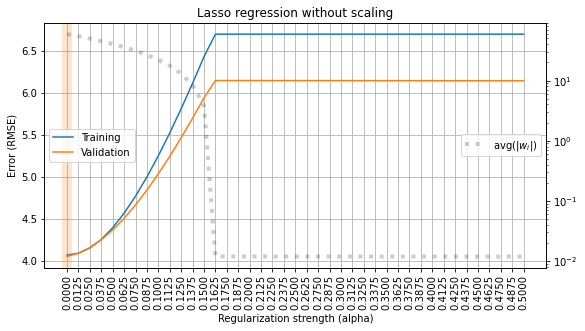

In [50]:
## your code
rmse_train, rmse_valid, all_coef_l1, avg_coef = count_rmse_coef(X_train_4, X_valid_4, y_train_4, y_valid_4, \
                                                             reg_type='L1')
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso regression without scaling')

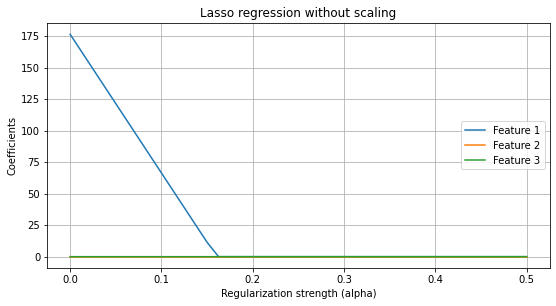

In [51]:
plot_weights(all_coef_l1, 'L1')

Let's look at the changes in each weight on separate plots.

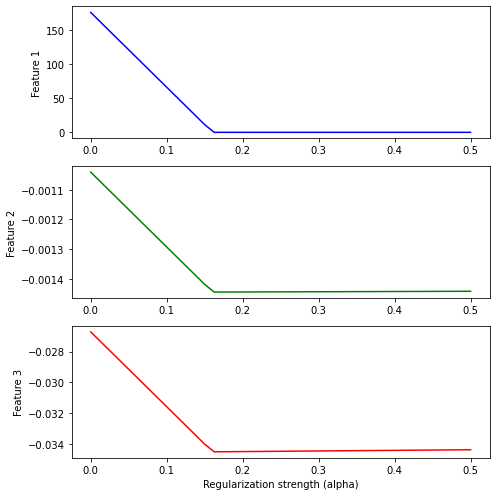

In [52]:
subplot_weights(all_coef_l1)

Min of feature 0: -1.49, max: 1.83
Min of feature 1: -1.66, max: 1.54
Min of feature 2: -2.14, max: 2.24


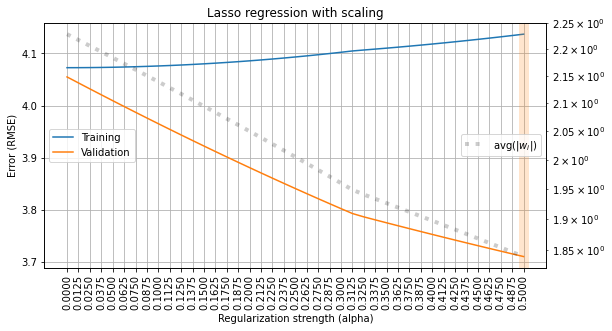

In [53]:
## your code
X_train_4_scaled, X_valid_4_scaled = scale_print_min_max(X_hw, X_train_4, X_valid_4)

rmse_train, rmse_valid, all_coef_l1_sc, avg_coef = count_rmse_coef(X_train_4_scaled, X_valid_4_scaled, \
                                                          y_train_4, y_valid_4, reg_type='L1')
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                    title='Lasso regression with scaling')

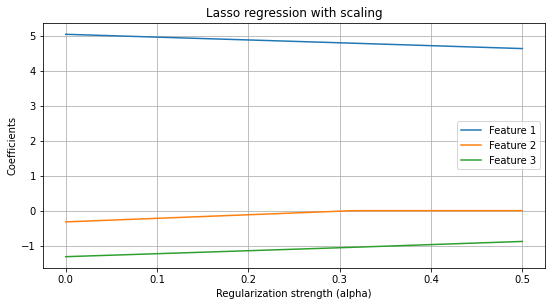

In [54]:
plot_weights(all_coef_l1_sc, 'L1', scaled=True)

#### L2

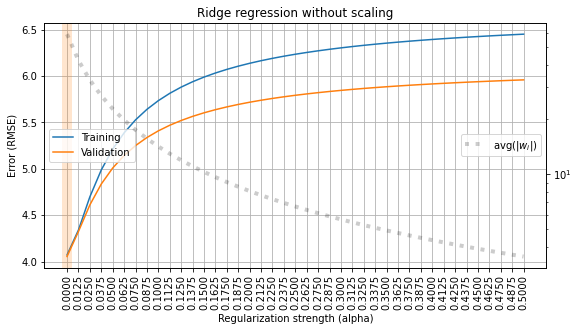

In [55]:
# your code
rmse_train, rmse_valid, all_coef_l2, avg_coef = count_rmse_coef(X_train_4, X_valid_4, y_train_4, y_valid_4, \
                                                             reg_type='L2')
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge regression without scaling')

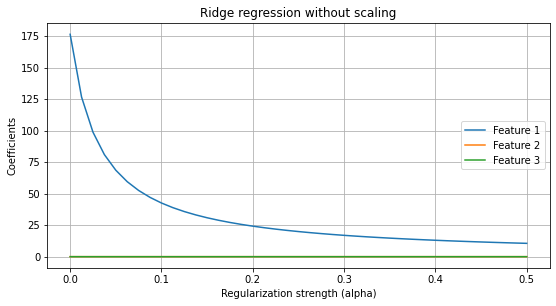

In [56]:
plot_weights(all_coef_l2, 'L2')

Let's look at the changes in each weight on separate plots.

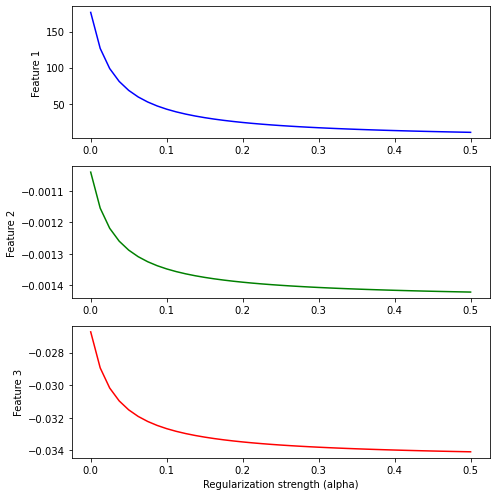

In [57]:
subplot_weights(all_coef_l2)

Min of feature 0: -1.49, max: 1.83
Min of feature 1: -1.66, max: 1.54
Min of feature 2: -2.14, max: 2.24


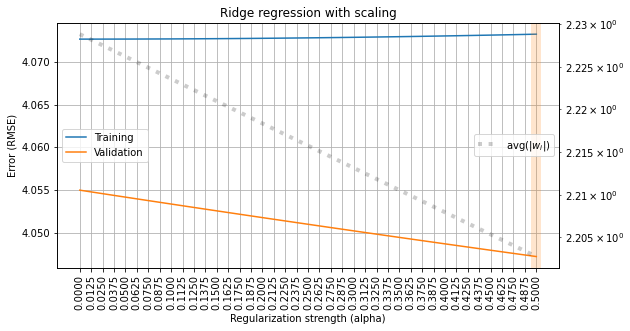

In [58]:
## your code
X_train_4_scaled, X_valid_4_scaled = scale_print_min_max(X_hw, X_train_4, X_valid_4)


rmse_train, rmse_valid, all_coef_l2_sc, avg_coef = count_rmse_coef(X_train_4_scaled, X_valid_4_scaled, \
                                                          y_train_4, y_valid_4, reg_type='L2')
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                    title='Ridge regression with scaling')

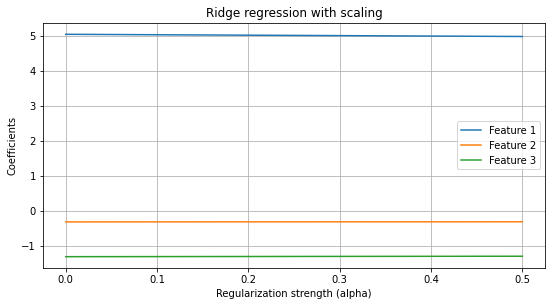

In [59]:
plot_weights(all_coef_l2_sc, 'L2', scaled=True)

Let's look at the changes in each weight on separate plots.

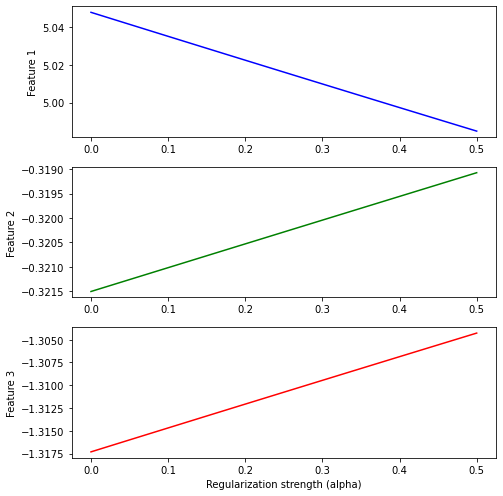

In [60]:
subplot_weights(all_coef_l2_sc)

#### Summary



As we can see, scaling is really important, because:

1) it helps us to understand, what feature has how much influence on the predicted outcome;

2) L1 and L2 regularizations doesn't work well and even overfit the model when data with high difference of scales are used. It's happenning because constraining of weights makes coefficients of features with small values too large and coefficients of features with large values too small so they can not influence the target sufficiently.